# PULSIM: pulse simulator


In [ ]:
!git clone --branch v_torch https://github.com/phillip-jaeslee/PULSIM
%cd PULSIM
!pip install -r requirements.txt

Cloning into 'PULSIM'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 471 (delta 24), reused 36 (delta 9), pack-reused 417
Receiving objects: 100% (471/471), 1.46 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (244/244), done.
/content/PULSIM
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 8.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-no

1st pulse "/content/PULSIM/GaussCascadeQ5" running...
elapsed time: 2.019973039627075 sec
2nd pulse "hard" running...


<ipython-input-4-5ba54d20fb39>:191: ComplexWarning: Casting complex values to real discards the imaginary part
  M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] =torch_pulse.torch_import_shaped_pulse(M, flip[i], angles[i], t_max[i], file_paths[i], BW, Gamma)


elapsed time: 1.865837574005127 sec
3rd pulse "/content/PULSIM/GaussCascadeQ5" running...
elapsed time: 1.3024027347564697 sec


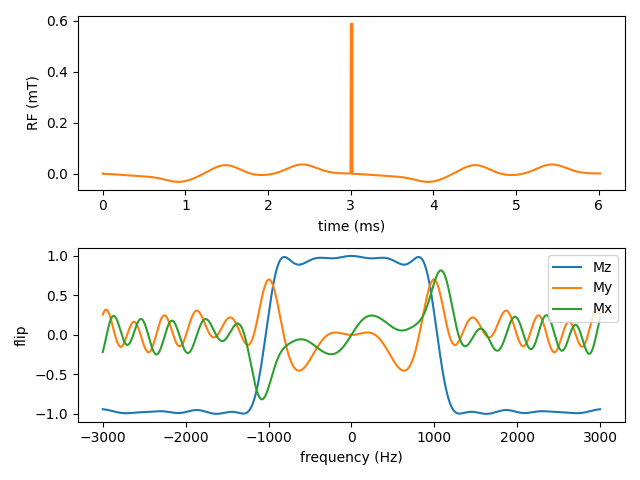

In [ ]:
#@title Input pulse parameters, then hit `Runtime` -> `Run all`

import numpy as np
import numpy.matlib
from bloch import bloch_rotate
import matplotlib.pyplot as plt
from pulse import torch_pulse, cpu_pulse
from input_parameter import gyro_ratio, get_spin_parameters, get_pulse_parameters, number_to_words
from numba import jit, cuda

from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

#@markdown Copy file_path by clicking right side of mouse `copy path`
#@markdown ---
#@markdown Choose the parameters below.
nucleus = 'H' #@param ['H', 'D', 'T', '13C', '15N'] {type:"string"}
num_pulse = 3 #@param [1, 2, 3, 4, 5] {type:"raw"}
bandwidth = 6 #@param {type:"raw"}
init_vect = 'z' #@param ['x', 'y', 'z'] {type:"string"}
BW = bandwidth

Gamma = gyro_ratio(nucleus)

M0 = 1

if (init_vect == 'x'):
    M_equilibrium = np.array([M0, 0, 0])
elif (init_vect == 'y'):
    M_equilibrium = np.array([0, M0, 0])
elif (init_vect == 'z'):
    M_equilibrium = np.array([0, 0, M0])
else:
    raise ValueError(f'There is no such "{init_vect}" coordinates. Please choose again.')


df = np.linspace(-BW/2, BW/2, num=1000)
N_t = 1000

M = np.tile(M_equilibrium, (len(df), 1)).T
M = M.astype(float)

df_temp = np.ndarray(shape=(num_pulse, 1, 1000))
RF_temp = np.ndarray(shape=(num_pulse, 1, N_t))
t_max_temp = np.ndarray(shape=(num_pulse, 1))


pulse_type = []
file_paths = []
flip = []
angles = []
t_max = []
N = []
shape = []
#@markdown ---
#@markdown Choose the parameters for the first pulse.
pulse_type_1 = 'composite' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_1 == 'composite':
  pulse_type_temp_1 = 1
elif pulse_type_1 == 'hard':
  pulse_type_temp_1 = 2
elif pulse_type_1 == 'shape':
  pulse_type_temp_1 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_1 = '/content/PULSIM/GaussCascadeQ5' #@param {type:"string"}
flip_1 = 90 #@param {type:"raw"}
angles_1 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_1 = 3 #@param {type:"raw"}
N_1 = 1000 #@param {type:"raw"}
shape_1 = '' #@param {type:"string"}


pulse_type.append(pulse_type_temp_1)
file_paths.append(file_path_1)
flip.append(flip_1)
angles.append(angles_1)
t_max.append(t_max_1)
shape.append(shape_1)
N.append(N_1)

#@markdown ---
#@markdown Choose the parameters for the second pulse.
pulse_type_2 = 'hard' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_2 == 'composite':
  pulse_type_temp_2 = 1
elif pulse_type_2 == 'hard':
  pulse_type_temp_2 = 2
elif pulse_type_2 == 'shape':
  pulse_type_temp_2 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_2 = '' #@param {type:"string"}
flip_2 = 180 #@param {type:"raw"}
angles_2 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_2 = 0.02 #@param {type:"raw"}
N_2 = 1000 #@param {type:"raw"}
shape_2 = '' #@param {type:"string"}

pulse_type.append(pulse_type_temp_2)
file_paths.append(file_path_2)
flip.append(flip_2)
angles.append(angles_2)
t_max.append(t_max_2)
shape.append(shape_2)
N.append(N_2)
#@markdown ---
#@markdown Choose the parameters for the third pulse.
pulse_type_3 = 'composite' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_3 == 'composite':
  pulse_type_temp_3 = 1
elif pulse_type_3 == 'hard':
  pulse_type_temp_3 = 2
elif pulse_type_3 == 'shape':
  pulse_type_temp_3 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_3 = '/content/PULSIM/GaussCascadeQ5' #@param {type:"string"}
flip_3 = 90.0 #@param {type:"raw"}
angles_3 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_3 = 3 #@param {type:"raw"}
N_3 = 1000 #@param {type:"raw"}
shape_3 = '' #@param {type:"string"}

pulse_type.append(pulse_type_temp_3)
file_paths.append(file_path_3)
flip.append(flip_3)
angles.append(angles_3)
t_max.append(t_max_3)
shape.append(shape_3)
N.append(N_3)
#@markdown ---
#@markdown Choose the parameters for the fourth pulse.
pulse_type_4 = 'hard' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_4 == 'composite':
  pulse_type_temp_4 = 1
elif pulse_type_4 == 'hard':
  pulse_type_temp_4 = 2
elif pulse_type_4 == 'shape':
  pulse_type_temp_4 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_4 = '' #@param {type:"string"}
flip_4 = 90.0 #@param {type:"raw"}
angles_4 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_4 = 10 #@param {type:"raw"}
N_4 = 1000 #@param {type:"raw"}
shape_4 = 'sine' #@param {type:"string"}

pulse_type.append(pulse_type_temp_4)
file_paths.append(file_path_4)
flip.append(flip_4)
angles.append(angles_4)
t_max.append(t_max_4)
shape.append(shape_4)
N.append(N_4)
#@markdown ---
#@markdown Choose the parameters for the fifth pulse.
pulse_type_5 = 'hard' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_5 == 'composite':
  pulse_type_temp_5 = 1
elif pulse_type_5 == 'hard':
  pulse_type_temp_5 = 2
elif pulse_type_5 == 'shape':
  pulse_type_temp_5 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_5 = '' #@param {type:"string"}
flip_5 = 90.0 #@param {type:"raw"}
angles_5 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_5 = 10 #@param {type:"raw"}
N_5 = 1000 #@param {type:"raw"}
shape_5 = 'sine' #@param {type:"string"}

pulse_type.append(pulse_type_temp_5)
file_paths.append(file_path_5)
flip.append(flip_5)
angles.append(angles_5)
t_max.append(t_max_5)
shape.append(shape_5)
N.append(N_5)

for num_flip in range(len(flip)):
  flip[num_flip] = flip[num_flip] / 180 * np.pi


for i in range(num_pulse):
    if pulse_type[i] == 1:
        print(f'{number_to_words(i+1)} pulse "{file_paths[i]}" running...')
        M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] =torch_pulse.torch_import_shaped_pulse(M, flip[i], angles[i], t_max[i], file_paths[i], BW, Gamma)
    elif pulse_type[i] == 2:
        print(f'{number_to_words(i+1)} pulse "hard" running...')
        M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] = torch_pulse.torch_hard_pulse(M, flip[i], angles[i], t_max[i], N[i], BW, Gamma)
    elif pulse_type[i] == 3:
        print(f'{number_to_words(i+1)} pulse "{shape[i]}" running...')
        M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] = torch_pulse.torch_shaped_pulse(M, flip[i], angles[i], t_max[i], shape[i], N[i], BW, Gamma)
    else:
        raise ValueError(f'Error of pulse type')

RF_t = np.zeros(shape=(1, np.sum(N)), dtype='float')

for n in range(num_pulse):
    RF_t = np.append(RF_t, RF_temp[n, :, :])

t_temp = np.zeros(shape=(num_pulse, N_t), dtype='float')
t = np.zeros(shape=(np.sum(N)), dtype='float')

for j in range(num_pulse):
    t_temp[j] = np.arange(0, N[j], 1) * t_max_temp[j] / N[j]
    k = 0
    for k in range(j):
        t_temp[j] = t_temp[j] + t_max_temp[k]

for r in range(num_pulse):
    t = np.append(t, t_temp[r])


fig, axs = plt.subplots(2, 1)
axs[0].plot(t[0]-np.finfo(np.float64).eps, 0)
axs[0].plot(t, RF_t.T)
axs[0].plot(t[-1]+np.finfo(np.float64).eps, 0)
axs[0].set(xlabel='time (ms)', ylabel='RF (mT)')
df = df * 1000
axs[1].plot(df, M[2,:], label="Mz")
axs[1].plot(df, M[1,:], label="My")
axs[1].plot(df, M[0,:], label="Mx")
axs[1].set(xlabel='frequency (Hz)', ylabel='flip')
axs[1].legend()
fig.tight_layout()
plt.ion()
plt.show()

1st pulse "/content/PULSIM/GaussCascadeQ5" running...
elapsed time: 63.40787172317505 sec
2nd pulse "hard" running...


<ipython-input-3-672d683f6420>:192: ComplexWarning: Casting complex values to real discards the imaginary part
  M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] =cpu_pulse.import_shaped_pulse(M, flip[i], angles[i], t_max[i], file_paths[i], BW, Gamma, MULTI)


elapsed time: 65.62049436569214 sec
3rd pulse "/content/PULSIM/GaussCascadeQ5" running...
elapsed time: 61.10697054862976 sec


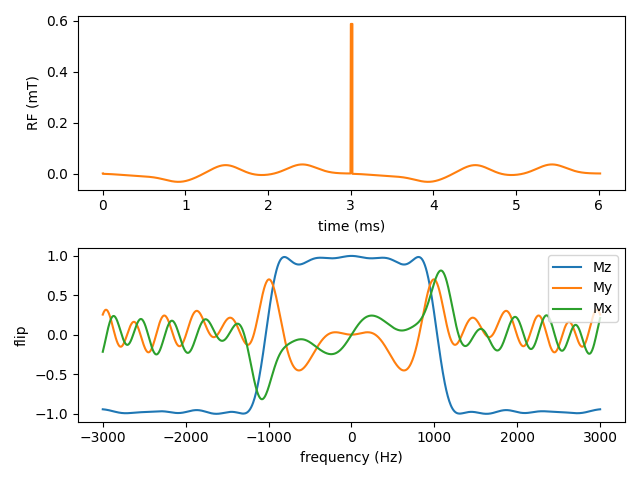

In [ ]:
#@title Input pulse parameters, then hit `Runtime` -> `Run all`

import numpy as np
import numpy.matlib
from bloch import bloch_rotate
import matplotlib.pyplot as plt
from pulse import torch_pulse, cpu_pulse
from input_parameter import gyro_ratio, get_spin_parameters, get_pulse_parameters, number_to_words
from numba import jit, cuda

from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

#@markdown Copy file_path by clicking right side of mouse `copy path`
#@markdown ---
#@markdown Choose the parameters below.
nucleus = 'H' #@param ['H', 'D', 'T', '13C', '15N'] {type:"string"}
num_pulse = 3 #@param [1, 2, 3, 4, 5] {type:"raw"}
bandwidth = 6 #@param {type:"raw"}
init_vect = 'z' #@param ['x', 'y', 'z'] {type:"string"}
BW = bandwidth

Gamma = gyro_ratio(nucleus)

M0 = 1

if (init_vect == 'x'):
    M_equilibrium = np.array([M0, 0, 0])
elif (init_vect == 'y'):
    M_equilibrium = np.array([0, M0, 0])
elif (init_vect == 'z'):
    M_equilibrium = np.array([0, 0, M0])
else:
    raise ValueError(f'There is no such "{init_vect}" coordinates. Please choose again.')


df = np.linspace(-BW/2, BW/2, num=1000)
N_t = 1000

M = np.tile(M_equilibrium, (len(df), 1)).T
M = M.astype(float)

df_temp = np.ndarray(shape=(num_pulse, 1, 1000))
RF_temp = np.ndarray(shape=(num_pulse, 1, N_t))
t_max_temp = np.ndarray(shape=(num_pulse, 1))


pulse_type = []
file_paths = []
flip = []
angles = []
t_max = []
N = []
shape = []
#@markdown ---
#@markdown Choose the parameters for the first pulse.
pulse_type_1 = 'composite' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_1 == 'composite':
  pulse_type_temp_1 = 1
elif pulse_type_1 == 'hard':
  pulse_type_temp_1 = 2
elif pulse_type_1 == 'shape':
  pulse_type_temp_1 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_1 = '/content/PULSIM/GaussCascadeQ5' #@param {type:"string"}
flip_1 = 90 #@param {type:"raw"}
angles_1 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_1 = 3 #@param {type:"raw"}
N_1 = 1000 #@param {type:"raw"}
shape_1 = '' #@param {type:"string"}


pulse_type.append(pulse_type_temp_1)
file_paths.append(file_path_1)
flip.append(flip_1)
angles.append(angles_1)
t_max.append(t_max_1)
shape.append(shape_1)
N.append(N_1)

#@markdown ---
#@markdown Choose the parameters for the second pulse.
pulse_type_2 = 'hard' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_2 == 'composite':
  pulse_type_temp_2 = 1
elif pulse_type_2 == 'hard':
  pulse_type_temp_2 = 2
elif pulse_type_2 == 'shape':
  pulse_type_temp_2 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_2 = '' #@param {type:"string"}
flip_2 = 180 #@param {type:"raw"}
angles_2 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_2 = 0.02 #@param {type:"raw"}
N_2 = 1000 #@param {type:"raw"}
shape_2 = '' #@param {type:"string"}

pulse_type.append(pulse_type_temp_2)
file_paths.append(file_path_2)
flip.append(flip_2)
angles.append(angles_2)
t_max.append(t_max_2)
shape.append(shape_2)
N.append(N_2)
#@markdown ---
#@markdown Choose the parameters for the third pulse.
pulse_type_3 = 'composite' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_3 == 'composite':
  pulse_type_temp_3 = 1
elif pulse_type_3 == 'hard':
  pulse_type_temp_3 = 2
elif pulse_type_3 == 'shape':
  pulse_type_temp_3 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_3 = '/content/PULSIM/GaussCascadeQ5' #@param {type:"string"}
flip_3 = 90.0 #@param {type:"raw"}
angles_3 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_3 = 3 #@param {type:"raw"}
N_3 = 1000 #@param {type:"raw"}
shape_3 = '' #@param {type:"string"}

pulse_type.append(pulse_type_temp_3)
file_paths.append(file_path_3)
flip.append(flip_3)
angles.append(angles_3)
t_max.append(t_max_3)
shape.append(shape_3)
N.append(N_3)
#@markdown ---
#@markdown Choose the parameters for the fourth pulse.
pulse_type_4 = 'hard' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_4 == 'composite':
  pulse_type_temp_4 = 1
elif pulse_type_4 == 'hard':
  pulse_type_temp_4 = 2
elif pulse_type_4 == 'shape':
  pulse_type_temp_4 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_4 = '' #@param {type:"string"}
flip_4 = 90.0 #@param {type:"raw"}
angles_4 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_4 = 10 #@param {type:"raw"}
N_4 = 1000 #@param {type:"raw"}
shape_4 = 'sine' #@param {type:"string"}

pulse_type.append(pulse_type_temp_4)
file_paths.append(file_path_4)
flip.append(flip_4)
angles.append(angles_4)
t_max.append(t_max_4)
shape.append(shape_4)
N.append(N_4)
#@markdown ---
#@markdown Choose the parameters for the fifth pulse.
pulse_type_5 = 'hard' #@param ['composite', 'hard', 'shape'] {type:"string"}
if pulse_type_5 == 'composite':
  pulse_type_temp_5 = 1
elif pulse_type_5 == 'hard':
  pulse_type_temp_5 = 2
elif pulse_type_5 == 'shape':
  pulse_type_temp_5 = 3
else:
  raise ValueError(f'Error of pulse type')
file_path_5 = '' #@param {type:"string"}
flip_5 = 90.0 #@param {type:"raw"}
angles_5 = 'x' #@param ['x', 'y', 'z'] {type:"string"}
t_max_5 = 10 #@param {type:"raw"}
N_5 = 1000 #@param {type:"raw"}
shape_5 = 'sine' #@param {type:"string"}

pulse_type.append(pulse_type_temp_5)
file_paths.append(file_path_5)
flip.append(flip_5)
angles.append(angles_5)
t_max.append(t_max_5)
shape.append(shape_5)
N.append(N_5)

for num_flip in range(len(flip)):
  flip[num_flip] = flip[num_flip] / 180 * np.pi

MULTI = False

for i in range(num_pulse):
    if pulse_type[i] == 1:
        print(f'{number_to_words(i+1)} pulse "{file_paths[i]}" running...')
        M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] =cpu_pulse.import_shaped_pulse(M, flip[i], angles[i], t_max[i], file_paths[i], BW, Gamma, MULTI)
    elif pulse_type[i] == 2:
        print(f'{number_to_words(i+1)} pulse "hard" running...')
        M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] = cpu_pulse.hard_pulse(M, flip[i], angles[i], t_max[i], N[i], BW, Gamma, MULTI)
    elif pulse_type[i] == 3:
        print(f'{number_to_words(i+1)} pulse "{shape[i]}" running...')
        M, df_temp[i], RF_temp[i], t_max_temp[i], N[i] = cpu_pulse.shaped_pulse(M, flip[i], angles[i], t_max[i], shape[i], N[i], BW, Gamma, MULTI)
    else:
        raise ValueError(f'Error of pulse type')

RF_t = np.zeros(shape=(1, np.sum(N)), dtype='float')

for n in range(num_pulse):
    RF_t = np.append(RF_t, RF_temp[n, :, :])

t_temp = np.zeros(shape=(num_pulse, N_t), dtype='float')
t = np.zeros(shape=(np.sum(N)), dtype='float')

for j in range(num_pulse):
    t_temp[j] = np.arange(0, N[j], 1) * t_max_temp[j] / N[j]
    k = 0
    for k in range(j):
        t_temp[j] = t_temp[j] + t_max_temp[k]

for r in range(num_pulse):
    t = np.append(t, t_temp[r])


fig, axs = plt.subplots(2, 1)
axs[0].plot(t[0]-np.finfo(np.float64).eps, 0)
axs[0].plot(t, RF_t.T)
axs[0].plot(t[-1]+np.finfo(np.float64).eps, 0)
axs[0].set(xlabel='time (ms)', ylabel='RF (mT)')
df = df * 1000
axs[1].plot(df, M[2,:], label="Mz")
axs[1].plot(df, M[1,:], label="My")
axs[1].plot(df, M[0,:], label="Mx")
axs[1].set(xlabel='frequency (Hz)', ylabel='flip')
axs[1].legend()
fig.tight_layout()
plt.ion()
plt.show()